# Tomorrow's Map Generation 
In this notebook we will use discrete optimization generating maps from predefined tiles in two dimensional space.

In [1]:
import numpy as np
import seaborn as sns

Let's define the number of available tiles, adjacency weights and the dimentions of the output map we would like to generate.

In [2]:
n_tiles = 4
map_dim = [8, 8]

The map generator problem can be formally defined as follows: We are given a set of tiles, consisting of $k$ items (for example,road, water,tree,grass) with pairwise interactions between ever tiles and weight $q_{ij}$ and a map consisting of $N x N$ tiles. Then the objective is to select a subset of tiles such that the output map is minimize with a set of constraints, for example, only one tile can be placed in a given map cell.

$$H = \sum_{i}^{N} q_{i} x_{i} + \sum_{i<j}^{N} q_{ij}x_{i}x_{j}$$

## Create BQM object

- Decision variables: $x_{ij} = k$ if the map cell i, j is assigned with the tile k
- Total number of variables: number of map cells times number of tiles

## Representation of map as Decision variables

Below is an example of variable construction.

row\column | 1 | 2 | 3 | 4 | 5 | 6
:----:|:---:|:----:|:----:|:----:|:-----:|:-----:
1     | x00 | x01   |x02   | x03   | x04  | x05
2     | x10 | x11   |x12   | x13   | x14  | x15
3     | x20 | x21   |x22   | x23   | x24  | x25

here each cell value corresponds to the respective tile index in the output map

In [3]:
from dimod import AdjVectorBQM

bqm = AdjVectorBQM('BINARY')

x = {(i, j, k): bqm.add_variable((f'x_{i}_{j}', k), 0)
     for i in range(map_dim[0])
     for j in range(map_dim[1])
     for k in range(n_tiles)
     }

## Add constraint
- Only one tile can be placed in a given map cell
- The sum of $x_{ijk}$ for all values of k (all possible tiles) amounts to one

In [4]:
one_hot_penalty = 100
for i in range(map_dim[0]):
    for j in range(map_dim[1]):
        bqm.add_linear_equality_constraint(
           [(x[i, j, k], 1.0) for k in range(n_tiles)],
           constant=-1.0,
           lagrange_multiplier=one_hot_penalty
           ) 

## Add soft constraints
- Pairwise interactions between every pair of tiles represent their relative association. This is given by the matrix coincidences 

In [1]:
coincidences =  np.array([[4., 6., 4., 8.],
                           [6., 0., 0., 4.],
                           [4., 0., 0., 0.],
                           [8., 4., 0., 5.]])

NameError: name 'np' is not defined

- The penalty is inverse proportional to the interaction parameter

In [ ]:
coincidence_prob = coincidences / coincidences.sum()
coincidence_nll = -np.log(coincidence_prob)

noise = 0.5
concidence_nll_noise = -np.log((coincidences + noise) / (coincidences + noise).sum())

$H_{tildes} = \sum_{i}^{N} q_{i} x_{i} + \sum_{i<j}^{N}\sum_{t_{i}}\sum_{t_{j}}\sum_{t_{k}} q_{ij}x_{i}x_{j}$

In [6]:
for i in range(map_dim[0]):
    for j in range(map_dim[1]):
        for k in [i-1, i+1]:
            if ((k<0) | (k>=map_dim[0]))==False:
                for t_i in range(n_tiles):
                    for t_k in range(n_tiles):
                        bqm.add_interaction(x[i, j, t_i], x[k, j, t_k], concidence_nll_noise[t_i][t_k])
        for l in [j-1, j+1]:
            if ((l<0) | (l>=map_dim[1]))==False:
                for t_j in range(n_tiles):
                    for t_l in range(n_tiles):
                        bqm.add_interaction(x[i, j, t_j], x[i, l, t_l], concidence_nll_noise[t_j][t_l])

## Run on Simulator/Real hardware

In [8]:
from dwave.system import DWaveSampler, EmbeddingComposite

In [12]:
sampler = EmbeddingComposite(DWaveSampler())
sampletest = sampler.sample(bqm, num_reads=10, chain_strength=150)

In [13]:
print(sampletest)

('x_0_0', 0) ('x_0_0', 1) ... ('x_7_7', 3)      energy num_oc. chain_b.
3            0            0 ...            1 1572.879949       1 0.003906
2            0            0 ...            1 1609.851576       1 0.003906
0            0            0 ...            1 1683.063671       1      0.0
1            0            0 ...            0 1685.956865       1      0.0
4            0            0 ...            0  1806.32849       1      0.0
5            0            0 ...            1 1904.655982       1      0.0
6            0            0 ...            1 1929.930722       1      0.0
7            0            0 ...            0 2130.934391       1      0.0
8            0            0 ...            0 2263.134894       1 0.003906
9            0            0 ...            0 2447.466827       1      0.0
['BINARY', 10 rows, 10 samples, 256 variables]


## Optimal solution

In [14]:
# Get the best solution 
best_solution = sampletest.first.sample
assignments = {grid_cell: tile_id for (grid_cell, tile_id), value in best_solution.items() if value}

print(assignments)

{'x_0_0': 3, 'x_0_1': 2, 'x_0_2': 0, 'x_0_3': 2, 'x_0_4': 1, 'x_0_5': 0, 'x_0_6': 3, 'x_0_7': 3, 'x_1_0': 2, 'x_1_1': 0, 'x_1_2': 1, 'x_1_3': 0, 'x_1_4': 3, 'x_1_5': 1, 'x_1_6': 3, 'x_1_7': 1, 'x_2_0': 0, 'x_2_1': 0, 'x_2_2': 2, 'x_2_3': 1, 'x_2_4': 2, 'x_2_5': 2, 'x_2_6': 1, 'x_2_7': 3, 'x_3_0': 3, 'x_3_1': 1, 'x_3_2': 2, 'x_3_3': 1, 'x_3_4': 1, 'x_3_5': 0, 'x_3_6': 2, 'x_3_7': 0, 'x_4_0': 3, 'x_4_1': 0, 'x_4_2': 3, 'x_4_3': 3, 'x_4_4': 2, 'x_4_5': 3, 'x_4_6': 0, 'x_4_7': 2, 'x_5_0': 3, 'x_5_1': 1, 'x_5_2': 3, 'x_5_3': 2, 'x_5_4': 1, 'x_5_5': 0, 'x_5_6': 0, 'x_5_7': 0, 'x_6_0': 2, 'x_6_1': 3, 'x_6_2': 3, 'x_6_3': 2, 'x_6_4': 2, 'x_6_5': 2, 'x_6_6': 0, 'x_6_7': 2, 'x_7_0': 0, 'x_7_1': 1, 'x_7_2': 1, 'x_7_3': 2, 'x_7_4': 0, 'x_7_5': 1, 'x_7_6': 1, 'x_7_7': 3}


## Convert the solution assignments to map 

In [15]:
output_map = np.array(list(assignments.values())).reshape(map_dim[0], map_dim[1])

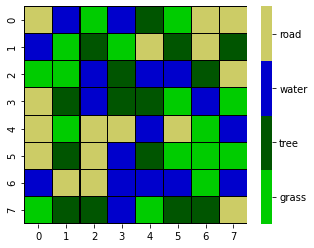

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5,4))

tile_names = ['grass', 'tree', 'water', 'road']
tile_colors  = ['#0c0', '#050', '#00c', '#cc6']
 
sns.heatmap(output_map, cmap=tile_colors, linewidth=0.1, linecolor='black', ax=ax)

colorbar = ax.collections[0].colorbar
M = output_map.max().max()
colorbar.set_ticks([(i + 0.5) * (n_tiles - 1) / n_tiles for i in range(n_tiles)])
colorbar.set_ticklabels(tile_names)

plt.show()

In [11]:
sampler.sample?

Signature:
sampler.sample(
    bqm,
    chain_strength=None,
    chain_break_method=None,
    chain_break_fraction=True,
    embedding_parameters=None,
    return_embedding=None,
    warnings=None,
    **parameters,
)
Docstring:
Sample from the provided binary quadratic model.

Args:
    bqm (:obj:`dimod.BinaryQuadraticModel`):
        Binary quadratic model to be sampled from.

    chain_strength (float/mapping/callable, optional):
        Sets the coupling strength between qubits representing variables 
        that form a :term:`chain`. Mappings should specify the required 
        chain strength for each variable. Callables should accept the BQM 
        and embedding and return a float or mapping. By default, 
        `chain_strength` is calculated with
        :func:`~dwave.embedding.chain_strength.uniform_torque_compensation`.

    chain_break_method (function/list, optional):
        Method or methods used to resolve chain breaks. If multiple
        methods are given, the resu